In [36]:
import numpy as np
x = np.array((3,5,2,-1))
print(np.max(x))
print(x -3)

def normalizer(v, lower_bound, upper_bound):
    return (2*v - lower_bound-upper_bound)/(upper_bound - lower_bound)

print(normalizer(x, -1, 5))

5
[ 0  2 -1 -4]
[ 0.33333333  1.          0.         -1.        ]


In [37]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import numpy as np
import math


#---------------------------------------------------
#--------------0 = A,B,C,D Pareto Optimal
#--------------1 = A,B,C Pareto Optimal
#--------------2 = A,C Pareto Optimal


p = 0.02
W = int(1/p)+1
tau = np.hstack([np.arange(0.0, 2.0, 0.01),np.arange(2.0, 10.0, 0.01),np.arange(10,100,2), np.arange(100,500,5)])
N_tau = np.size(tau)
epsilon = np.arange(21)*0.05
epsilon = np.around(epsilon, decimals = 3)
N_eps = np.size(epsilon)
REWARDS = np.array([0,4,9,10])
THREATS = np.array([0,-1,-4,-10])
OMEGA = np.array([THREATS, REWARDS])


def softmax(R,T):
    P = np.zeros((W,N_tau,4))
    for n in range(N_tau):
        for w in range(W):
            weight = [w*p, 1.0-w*p]
            temp = (weight[0]*R + weight[1]*T)*tau[n]
            temp = temp - np.max(temp)
            P[w,n,:] = np.exp(temp)/np.sum(np.exp(temp))
    learner = "Softmax One"
    return P, learner

def selective_attention(R,T):
    P = np.zeros((W,N_tau,4))
    for n in range(N_tau):
        ex_R = np.exp((R - np.max(R))*tau[n])
        ex_T = np.exp((T - np.max(T))*tau[n])
        weight_R = ex_R/np.sum(ex_R)
        weight_T = ex_T/np.sum(ex_T)
        for w in range(W):
            weight = [w*p,1.0-w*p]
            P[w,n,:] = weight[0]*weight_R + weight[1]*weight_T
    learner = "Softmax Two"
    return np.round(P,3), learner

def eps_greedy(R,T):
    P = np.zeros((W,N_eps,4))
    temp = np.zeros(4)
    for n in range(N_eps):
        for w in range(W):
            weight = [w*p, 1-w*p]
            for i in range(4):
                temp[i] = weight[0]*R[i] + weight[1]*T[i]
            k = np.argmax(temp)
            for i in range(4):
                if i == k:
                    P[w,n,i] = 1-0.75*epsilon[n]
                else:
                    P[w,n,i] = 0.25*epsilon[n]
    
    learner = "Epsilon-Greedy"
    return P, learner

#---- this only runs the selected decision_maker-------------
def run(decision_maker, R,T):
    if decision_maker!=eps_greedy:
        reward = np.zeros((W,N_tau))
        threat = np.zeros((W,N_tau))
        prob, _ = decision_maker(R,T)
        for w in range(W):
            for n in range(N_tau):
                reward[w,n] = np.dot(prob[w,n], R)
                threat[w,n] = np.dot(prob[w,n], T)
    else:
        reward = np.zeros((W,N_eps))
        threat = np.zeros((W,N_eps))
        prob, _ = decision_maker(R,T)
        for w in range(W):
            for n in range(N_eps):
                reward[w,n] = np.dot(prob[w,n], R)
                threat[w,n] = np.dot(prob[w,n], T)        
    return threat, reward

def rotate(x, y, theta):
    L = len(x)
    p = np.array([x,y])
    #print(p)
    xx = np.mean(x)
    yy = np.mean(y)
    m = np.zeros((2,L))
    for l in range(L):
        m[0,l] = xx
        m[1,l] = yy
    #print(m)
    rot_matrix = np.array([[math.cos(theta), - math.sin(theta)],
                         [math.sin(theta), math.cos(theta)]])
    rotated = np.dot(rot_matrix, np.array([x,y]) - m) + m
    return rotated
# given a single value of t = tau and w solver
def sa_solver(R, T, w, tau):
    R_den = R*tau - np.max(R*tau)
    T_den = T*tau - np.max(T*tau)
    R_plus = np.exp(R_den)/np.sum(np.exp(R_den))
    T_plus = np.exp(T_den)/np.sum(np.exp(T_den))
    temp = w*R_plus +(1-w)*T_plus
    y_value = np.dot(temp, R)
    x_value = np.dot(temp, T)
    return x_value, y_value


# this version's ref point is just a vector of max rewards for 
# for each objective.
def chebyshev(R,T,z):
    P = np.zeros((W,N_tau, 4))
    # z is the utopia/reference point
    # z = [np.max(THREATS), np.max(REWARDS)]
    for n in range(N_tau):
        for w in range(W):
            SQ = np.empty(4)
            weight = [w*p, 1.0-w*p]
            # for each action i we need to compute SQ(i)
            for i in range(4):
                SQ[i] = np.max(np.multiply(weight, np.abs(OMEGA[:,i] - z)))
            # print(SQ)
            temp = tau[n]*SQ

            # this is because minimum of SQ value is 
            # considered greediest - so we negate
            # for simplicity in Softmax.
            temp = float(-1.0)*temp
            #temp = temp - np.max(temp)
            # print(temp)

            # if n==80:
            #     print(tau[n], SQ[i])
            #     print(temp)
            P[w,n,:] = np.exp(temp)/np.sum(np.exp(temp))
    learner = "Chebyshev"
    return P, learner
#chebyshev(REWARDS,THREATS)

[[  0   0]
 [ -1   4]
 [ -4   9]
 [-10  10]]


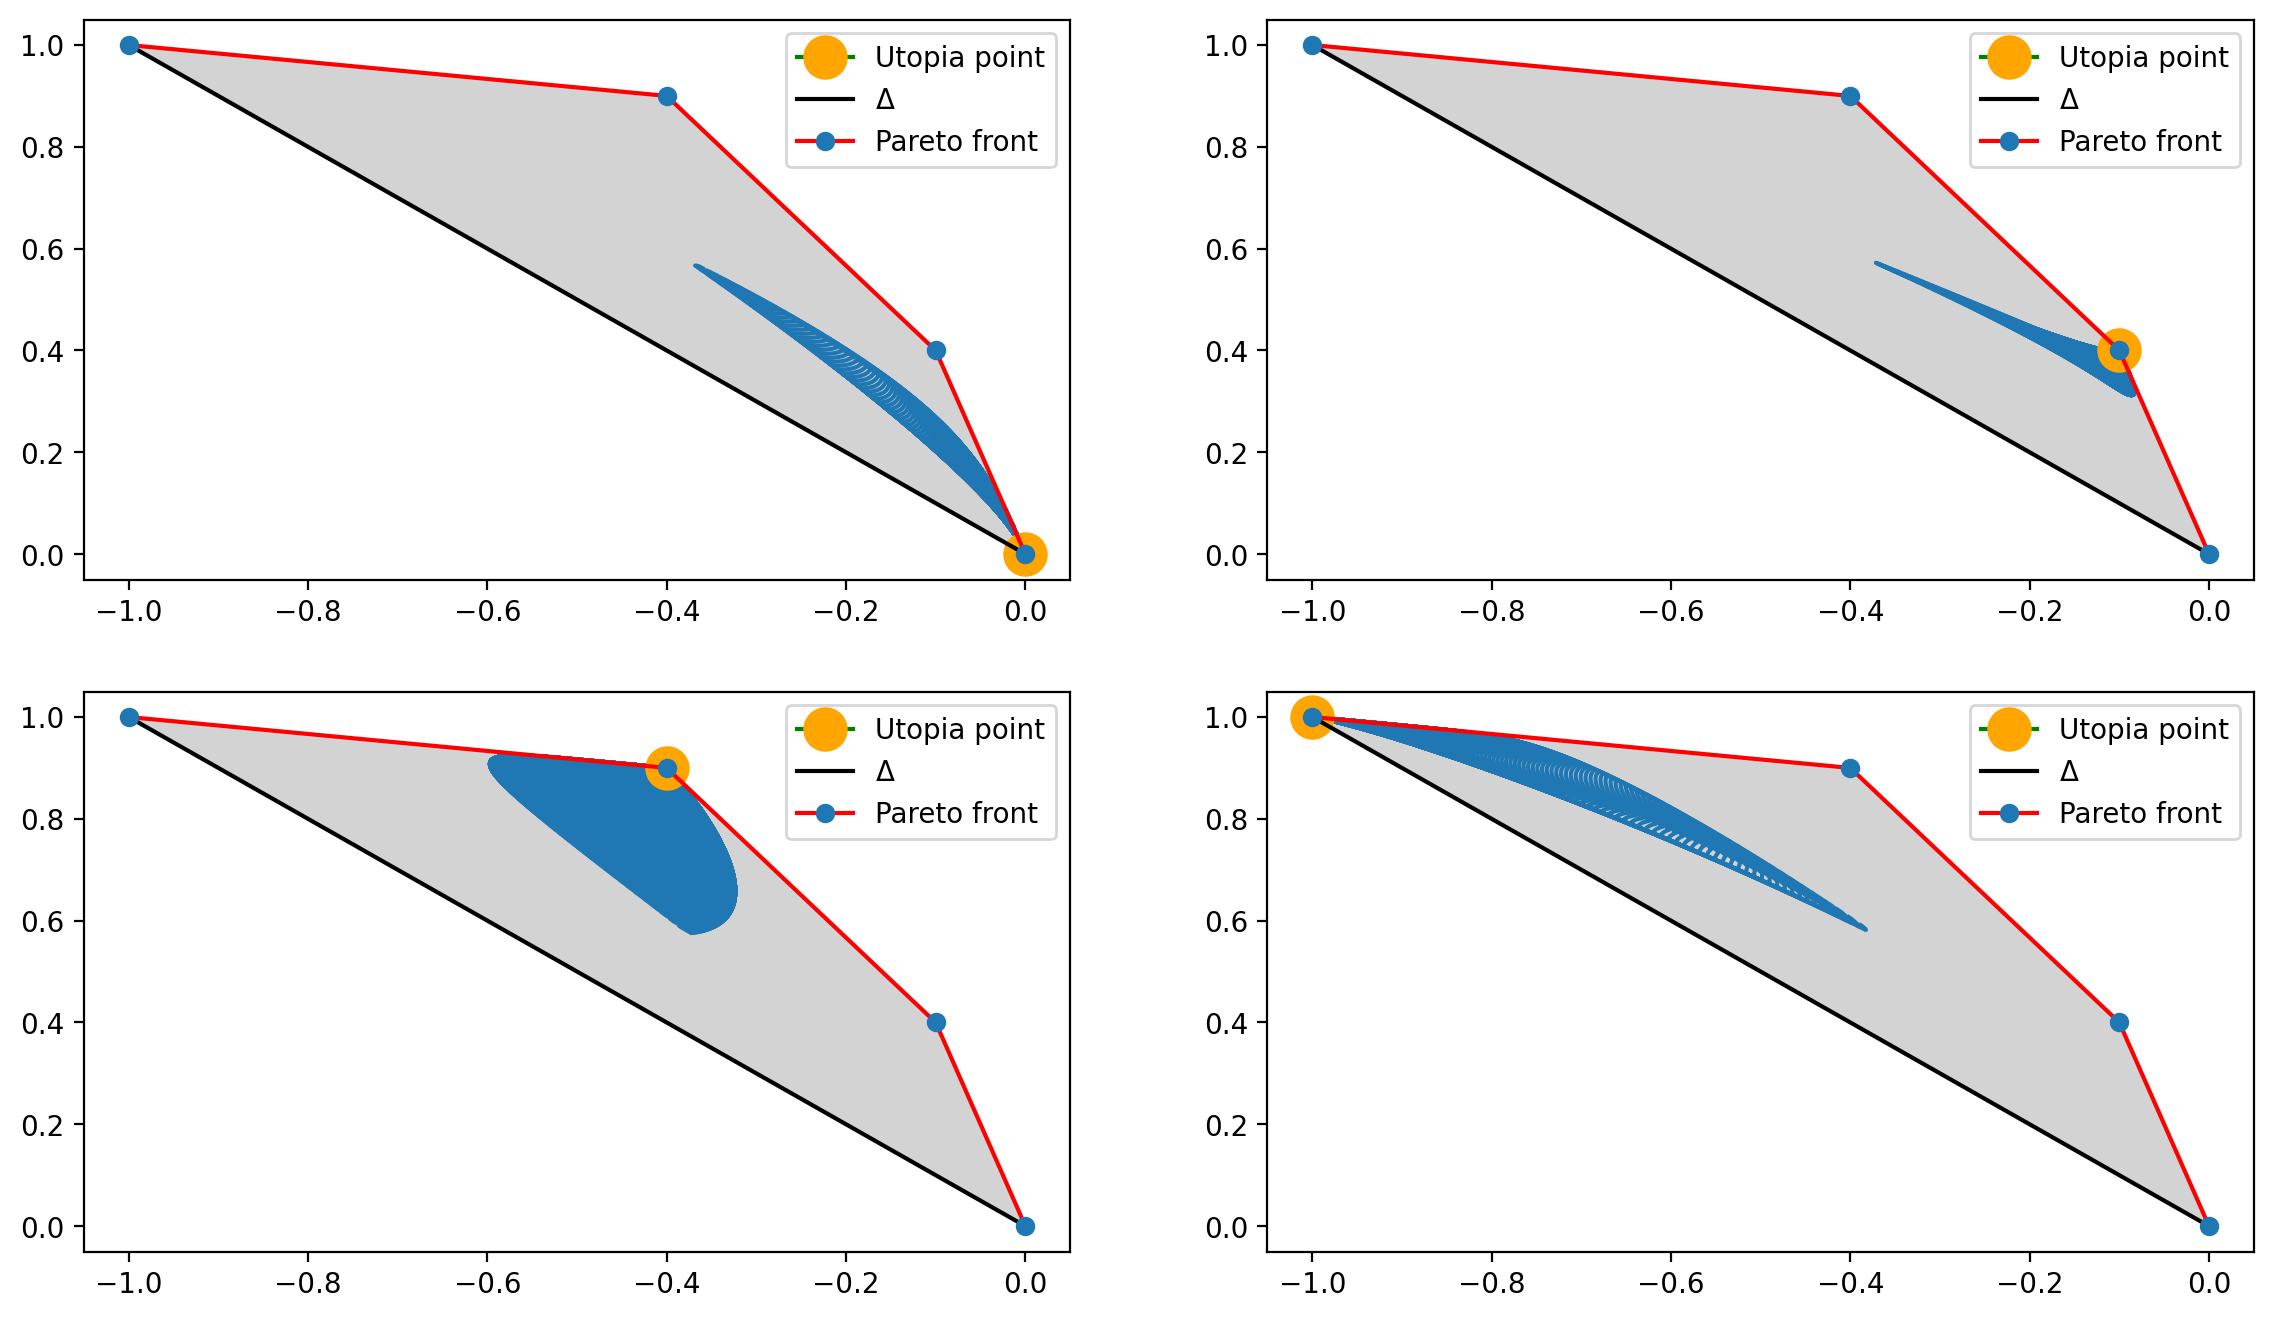

In [38]:
## print(OMEGA)
# print(chebyshev(REWARDS, THREATS))
# # print(run(chebyshev, REWARDS, THREATS)[0])

figure(figsize=(14, 8), dpi=200)
plt.figure(1)
R = REWARDS
T = THREATS
def normalizer(v, lower_bound, upper_bound):
    return (2*v - lower_bound-upper_bound)/(upper_bound - lower_bound)

def scale(x,y,z,T,R):
    return x.astype(float)/10.0, y.astype(float)/10.0, z.astype(float)/10.0, T.astype(float)/10.0, R.astype(float)/10.0


def run_chebyshev(R,T,z):
    reward = np.zeros((W,N_tau))
    threat = np.zeros((W,N_tau))
    prob, _ = chebyshev(R,T,z)
    for w in range(W):
        for n in range(N_tau):
            reward[w,n] = np.dot(prob[w,n], R)
            threat[w,n] = np.dot(prob[w,n], T)
    return threat, reward 

# T = normalizer(T, np.min(T), np.max(T))
# R = normalizer(R, np.min(R), np.max(R))  
# plot chebyshev
utopia_points = np.transpose(np.array([THREATS, REWARDS]))
print(utopia_points)
labels = ['Utopia point', '$\Delta$','Pareto front' ]
for i in range(4):
    z = utopia_points[i]
    x,y = run_chebyshev(REWARDS,THREATS,z)
    # x = normalizer(x, np.min(x), np.max(x))
    # y = normalizer(y, np.min(y), np.max(y))
 
    # plt.subplot(2,2,i+1)
    # plt.plot(x,y, color = '#1f77b4')
    # plt.plot(z[0], z[1], marker="o", markersize=15, markeredgecolor="orange", markerfacecolor="orange")
    # plt.plot([T[0], T[3]], [R[0], R[3]], color = 'black' )
    # plt.plot(T,R, color = 'red', marker = 'o', markerfacecolor = '#1f77b4', markeredgecolor = '#1f77b4')

    # scaling done here
    T,R = THREATS, REWARDS
    x,y,z,T,R = scale(x,y,z,T,R)
    ax = plt.subplot(2,2,i+1)
    ax.plot(x,y, color = '#1f77b4', label = '_nolegend_')
    ax.plot(z[0], z[1],color = 'green', marker="o", markersize=15, markeredgecolor="orange", markerfacecolor="orange")
    ax.plot([T[0], T[3]], [R[0], R[3]], color = 'black' )
    ax.plot(T,R, color = 'red', marker = 'o', markerfacecolor = '#1f77b4', markeredgecolor = '#1f77b4')
    # ax.legend(handles = [line1, line2,line3,line4])
    ax.legend(labels)
    # filling with shade using pyplot fill_between
    x,y = T,R
    y1 = y
    y2 = [y[0]]
    m = (y[3] - y[0])/(x[3] - x[0])
    b = (y[0]*x[3] - y[3]*x[0])/(x[3] - x[0])

    y2.append(m*x[1]+b)
    y2.append(m*x[2]+b)
    y2.append(y[3])
    # print(np.shape(y1), np.shape(y2))

    plt.fill_between(x,y1,y2, color = 'lightgrey')
    
    #plt.legend(['$\Delta$', 'Feasible region','Pareto front', 'Utopia point'])
# 
# plt.suptitle("Chebyshev-scalarized decision-makers with different Utopia points")

/var/folders/f5/bpx25wxj2m52tnk3bylv_sv40000gn/T/ipykernel_7865/2266956417.py:142: RuntimeWarning: invalid value encountered in divide
  P[w,n,:] = np.exp(temp)/np.sum(np.exp(temp))


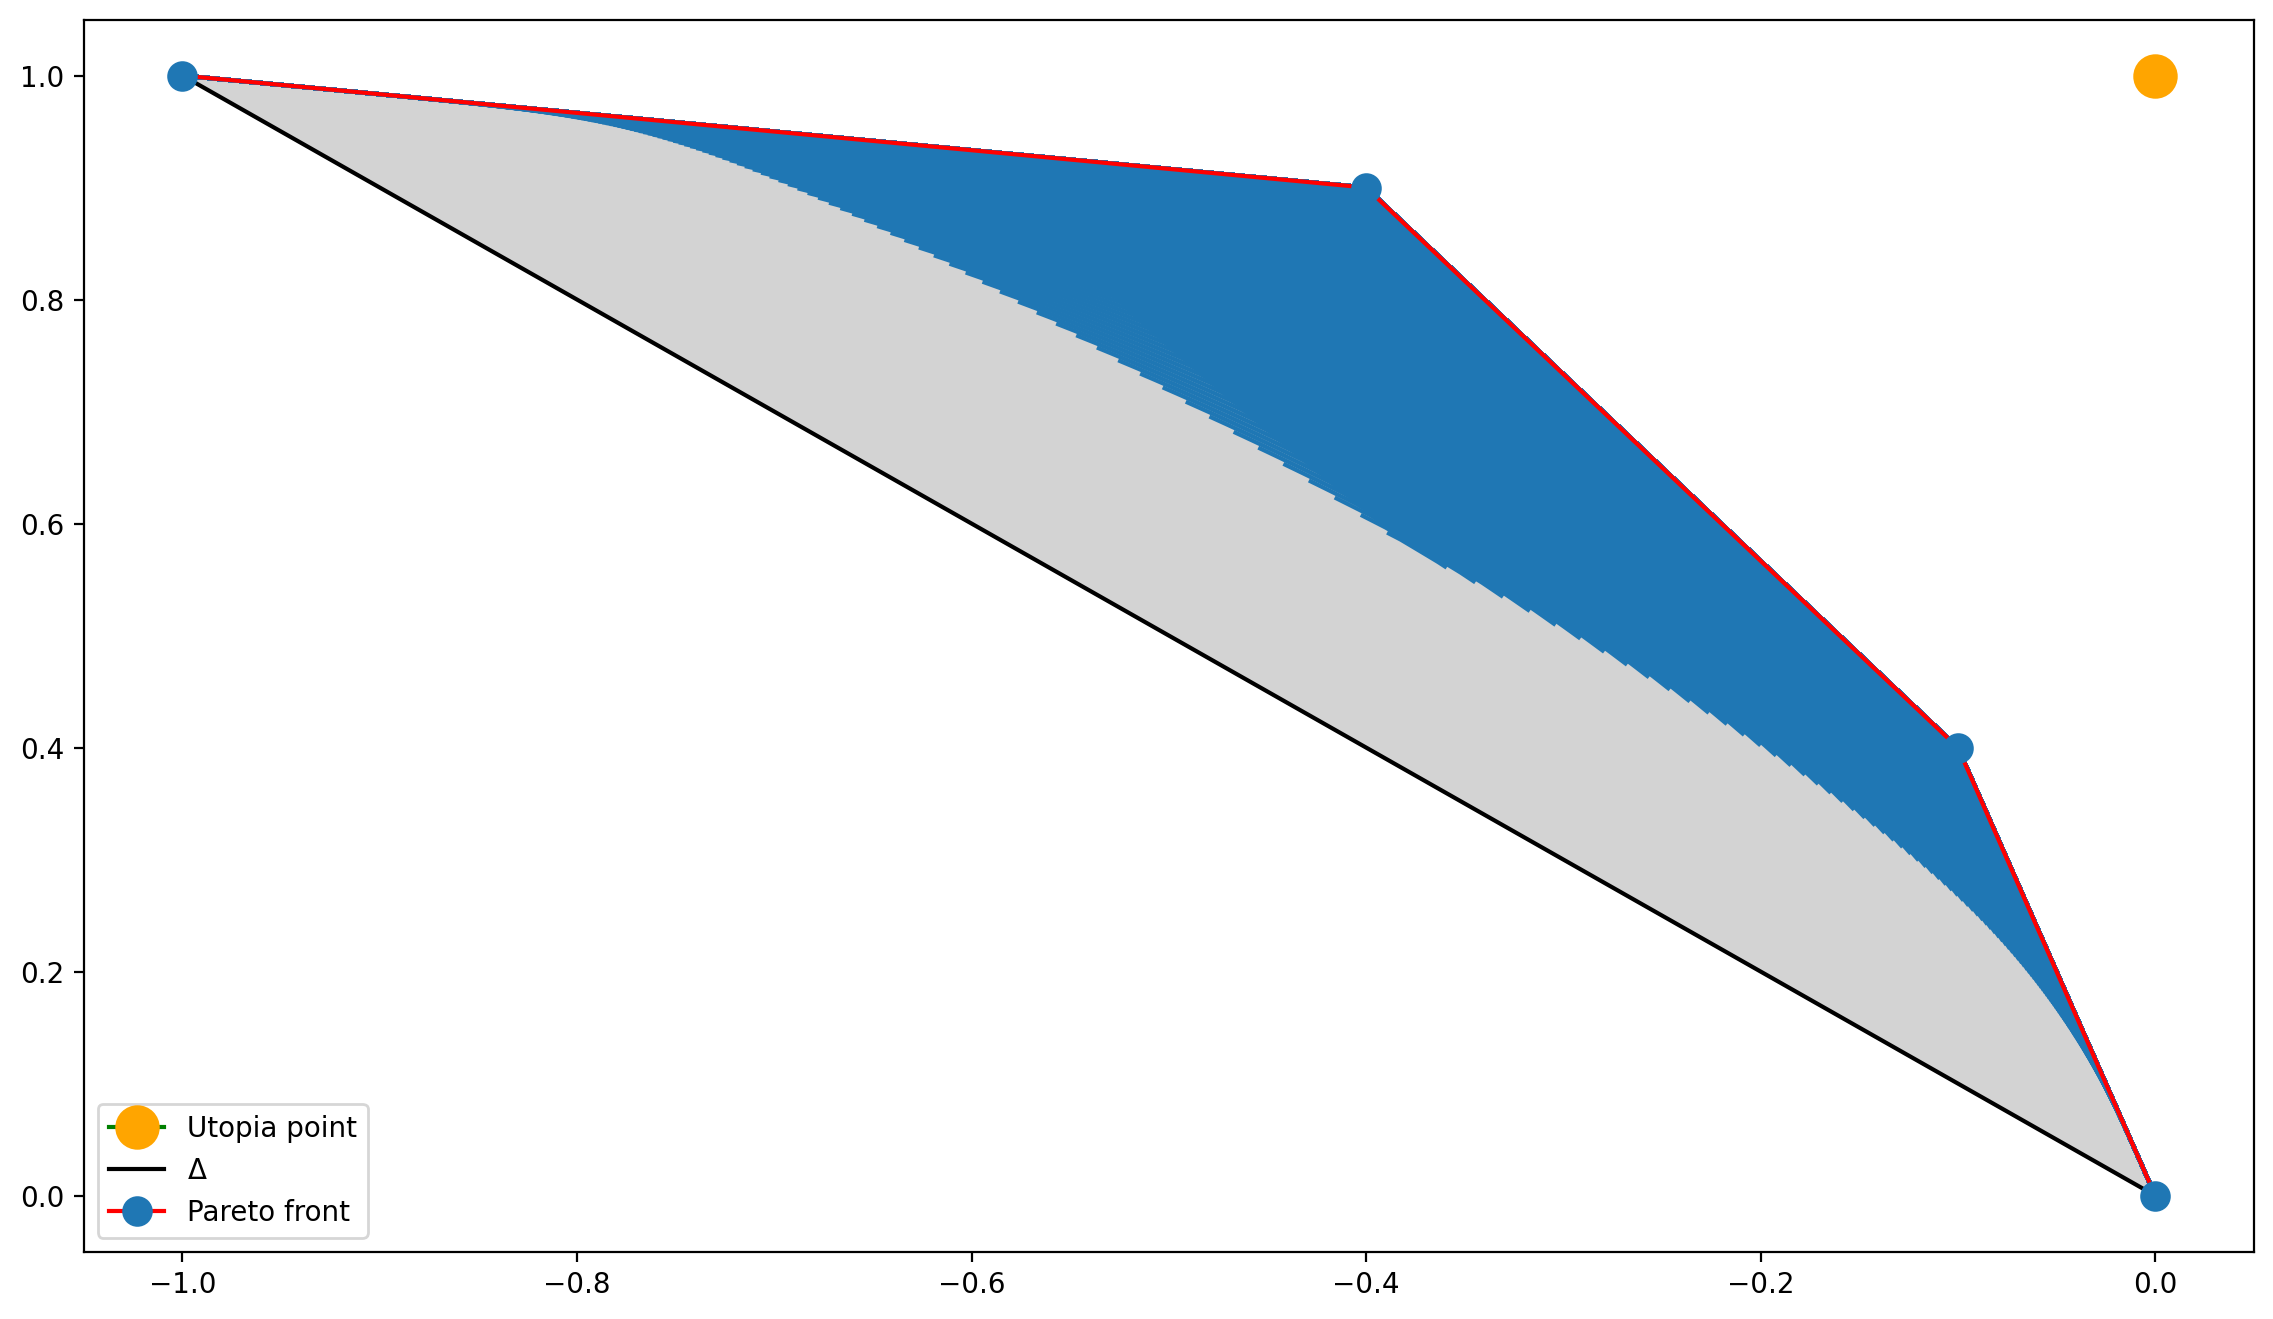

In [46]:
figure(figsize=(14, 8), dpi=200)
# Chebyshev scalarization with the Utopia point that is maximum of each dimension
Z = np.array([np.max(THREATS), np.max(REWARDS)])
x,y = run_chebyshev(REWARDS,THREATS,Z)
labels = ['Utopia point', '$\Delta$','Pareto front' ]

T,R = THREATS, REWARDS
x,y,Z,T,R = scale(x,y,Z,T,R)
ax = plt.subplot(1,1,1)
ax.plot(x,y, color = '#1f77b4', label = '_nolegend_')
ax.plot(Z[0], Z[1],color = 'green', marker="o", markersize=15, markeredgecolor="orange", markerfacecolor="orange")
ax.plot([T[0], T[3]], [R[0], R[3]], color = 'black' )
ax.plot(T,R, color = 'red', marker = 'o', markersize = 10, markerfacecolor = '#1f77b4', markeredgecolor = '#1f77b4')
# ax.legend(handles = [line1, line2,line3,line4])
ax.legend(labels)
# plt.suptitle("Feasible region of Chebyshev scalarization when the Utopia point maximizes each dimension")
x,y = T,R
y1 = y
y2 = [y[0]]
m = (y[3] - y[0])/(x[3] - x[0])
b = (y[0]*x[3] - y[3]*x[0])/(x[3] - x[0])

y2.append(m*x[1]+b)
y2.append(m*x[2]+b)
y2.append(y[3])
# print(np.shape(y1), np.shape(y2))

plt.fill_between(x,y1,y2, color = 'lightgrey')


(4,) (4,)
(2252,)


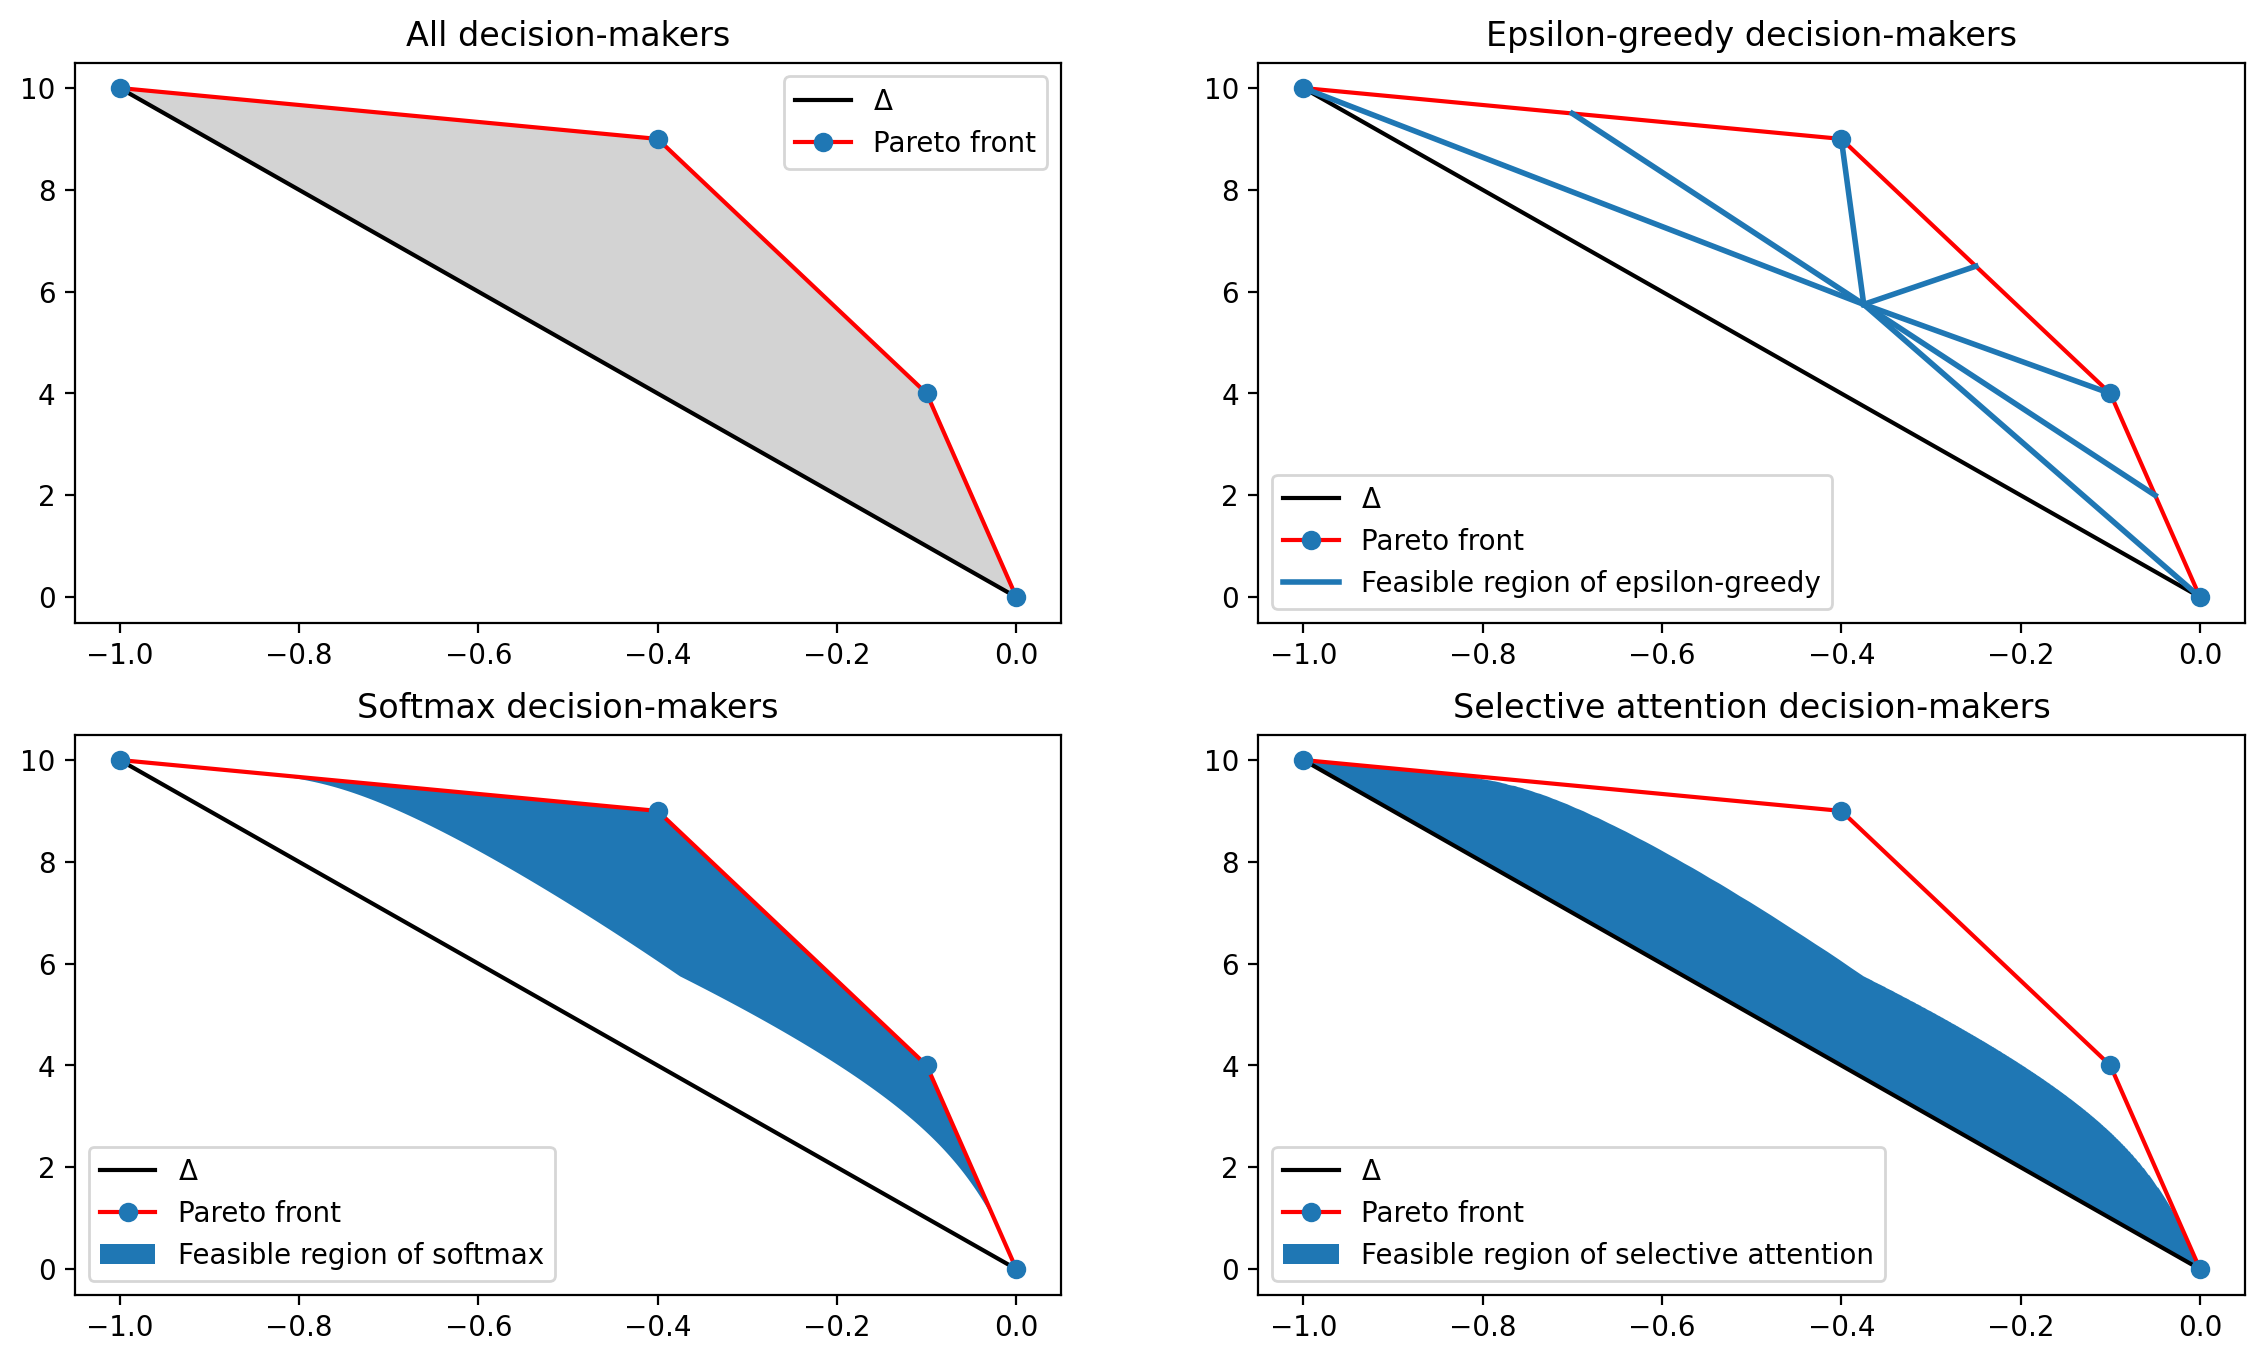

In [40]:
# Figure 5 in Chapter 4. Shows a non-trivial feasible space and the decision-makers' feasible regions. 
figure(figsize=(14, 8), dpi=200)
R = REWARDS
T = THREATS
T=T/np.max(-T)
decision_maker = [eps_greedy, selective_attention, softmax]
#-------An example of non-trivial Feasible Space-----------
plt.figure(1)
plt.subplot(2,2,1)
plt.plot([T[0], T[3]], [R[0], R[3]], color = 'black' )
plt.plot(T,R, color = 'red', marker = 'o', markerfacecolor = '#1f77b4', markeredgecolor = '#1f77b4')
# filling with shade using pyplot fill_between
x,y = T,R
y1 = y
y2 = [y[0]]
m = (y[3] - y[0])/(x[3] - x[0])
b = (y[0]*x[3] - y[3]*x[0])/(x[3] - x[0])

y2.append(m*x[1]+b)
y2.append(m*x[2]+b)
y2.append(y[3])
print(np.shape(y1), np.shape(y2))

plt.fill_between(x,y1,y2, color = 'lightgrey')

plt.title("All decision-makers")
plt.legend(['$\Delta$', 'Pareto front'])


#------Epsilon Greedy Feasible Region---------------
plt.subplot(2,2,2)
plt.plot([T[0], T[3]], [R[0], R[3]], color = 'black')
plt.plot(T,R, marker = 'o', color = 'red', markerfacecolor = '#1f77b4', markeredgecolor = '#1f77b4')
x,y = run(eps_greedy,R,T)
centroid =[np.mean(T), np.mean(R)]
for i in range(4):
    plt.plot([centroid[0], T[i]], [centroid[1], R[i]],c='#1f77b4', linewidth = 2)

for i in range(3):
    plt.plot([centroid[0], (T[i]+T[i+1])*0.5],[centroid[1], (R[i]+R[i+1])*0.5], c='#1f77b4', linewidth = 2)
plt.title("Epsilon-greedy decision-makers")
plt.legend(['$\Delta$', 'Pareto front',  'Feasible region of epsilon-greedy'])

#--------------Softmax Feasible Region--------------
plt.subplot(2,2,3)
plt.plot([T[0], T[3]], [R[0], R[3]], color = 'black')


x,y = run(softmax,R,T)
centroid =[np.mean(T), np.mean(R)]

#-fil_between takes some work here---
X = np.hstack([x[0], x[-1], T[3], T[0]])
Y = np.hstack([y[0], y[-1], R[3], R[0]])
X1 = np.argsort(X)
X = X[X1]
Y1= Y[X1] # y coordinate now sorted for the w = 0,1 boundaries
Y2 = [] # this is for the Pareto Front
m = np.zeros(3) # slopes of three line segments
b = np.zeros(3) # intercepts of three line segments
for i in range(0,3):
    m[2-i] = (R[3-i] - R[2-i])/(T[3-i] - T[2-i])
    b[2-i] = R[3-i] - m[2-i]*T[3-i]
id = 0

for i in range(0,3):
    while(X[id] < T[2-i]):
        Y2.append(m[2-i]*X[id]+b[2-i])
        id+=1
Y2.append(R[0])
print(np.shape(Y2))
plt.plot(T,R,color = 'red',marker = 'o', markerfacecolor = '#1f77b4', markeredgecolor = '#1f77b4')
plt.fill_between(X,Y1,Y2)

plt.title("Softmax decision-makers")
plt.legend(['$\Delta$', 'Pareto front', 'Feasible region of softmax'])

#---------------------Selective Attention Feasible Region-----------------------
plt.subplot(2,2,4)
plt.plot([T[0], T[3]], [R[0], R[3]], color = 'black')

x,y = run(selective_attention,R,T)
centroid =[np.mean(T), np.mean(R)]
#plt.plot(x[0], y[0])
#plt.plot(x[-1], y[-1])

#-fil_between takes some work here---
X = np.hstack([x[0], x[-1], T[3], T[0]])
Y = np.hstack([y[0], y[-1], R[3], R[0]])
X1 = np.argsort(X)
X = X[X1]

Y1= Y[X1] # y coordinate now sorted for the w = 0,1 boundaries
Y2 = [] # this is for the Pareto Front
m = (R[3] - R[0])/(T[3] - T[0]) # slopes of three line segments
b = R[3] - m*T[3]
Y2 = m*X+b
# print(m , b)
# print(np.shape(Y2))
plt.plot(T,R,color = 'red',marker = 'o', markerfacecolor = '#1f77b4', markeredgecolor = '#1f77b4')
plt.fill_between(X,Y1,Y2)

plt.title("Selective attention decision-makers")
plt.legend(['$\Delta$', 'Pareto front', 'Feasible region of selective attention'])

